# Purpose

This notebook uses the Alternating Least Squares matrix factorization method to produce recommendations for users following the approach in Ref. [1]. 

# Recommender system details

Our case is slightly different, and unfortunately, our dataset is a bit different. Namely we do not have access to information regarding time when ratings were posted, so our validation rather than being a before-v.s.-after train-validation split, we will have to do a random holdout cross-validation to determine the proper model parameters, particularly the number of latent factors and regularization. Additionally, in Ref. [1] that ratings correspond to the number of times a show was watched. While in principle data on number of plays by game could be gathered, with over 250k users in our dataset, and an expected O(10) pages of xml per player this would take far to long to scrape. 

Ignoring semantic differences between our dataset and that of Ref.[1], we will follow Ref. [1] in terms of optimization and evaluation metrics. Namely, given a rating matrix $R$ where rows of $R$ correspond to users, columns to items, and entries to ratings, we may form a matrix $P$ given by

$\begin{equation}
 p_{u,i} = \begin{cases} 
      1 & r_{u,i} > 0 \\
      0 & r_{u,i} = 0 
   \end{cases},
\end{equation}$

and 

$\begin{equation}
c_{u,i} = 1+\alpha r_{u,i}.
\end{equation}$

In the above equations, $P$ encodes user preferences for an item ($p_{u,i} = 0$ means we believe the user has no preference), and $C$ encodes our confidence in those preferences. Notice that our confidence increases as the rating increases where $\alpha > 0$ is a hyper parameter to be tuned in our model. We then attempt to find a factorization of $P$ as $p_{u,i} = x_u^Ty_i$ where the dimensionalities dim$(x_u) = $dim$(y_i) = n_f$ encode the dimensionality of the assumed latent space $n_f$. The optimization metric for training the factorization is given by

$\begin{equation}
\min\limits_{x_*,y_*} \sum\limits_{u,i} c_{u,i} (p_{u,i}-x_u^T y_i)^2 + \lambda \big(\sum\limits_{u} \|{x_u}\|^2 
+ \sum\limits_{i} \|y_i\|^2\big). 
\end{equation}$

I will optimize this loss function using the alternating least squares approach, where first $Y$ is fixed and $X$ which minimized the loss for fixed $Y$ is found. $X$ is then fixed and $Y$ is found. We repeat this process until convergence. I will use the pyspark ALS function for this purpose. However, if one were to code up the algorithm from scratch, analytic update formulas can be derived by taking partial derivatives of the loss function giving

$\begin{equation}
x_u = (Y^TC^uY+\lambda I)^{-1}Y^TC^up(u),\\
y_i = (X^TC^iX+\lambda I)^{-1}X^TC^ip(i),
\end{equation}$

where $C^u$ is the diagonal $n \times n$ matrix ($n$ is the number of items) where the entries are $C^u_{i,i} = c_{u,i}$, and $p(u) = p_{u,i}$ for fixed u is the vector of $p$'s by item for a given user. The definitions of $C^i$ and $p(i)$ ar analagous from the perspective of items instead of users.

# Interpreting recommendations

Notice that after training the algorithm by ALS on the loss function we may write our prediction for user u and item i $\hat{p}_{u,i}$ as

$\begin{align}
\hat{p}_{u,i} &= x_u^Ty_i\\
&= y_i^T x_u\\
&= y_i^T(Y^TC^uY+\lambda I)^{-1}Y^TC^up(u)\\
&\equiv y_i^TW^uY^TC^up(u).
\end{align}$

Now, notice that $p(u) = p_{u,j} \neq 0$ only for j in the users rated items giving

$\begin{align}
\hat{p}_{u,i} &= \sum\limits_{j:r_{u,j}>0} y_i^TW^uy_jc_{u,j}\\
&\equiv \sum\limits_{j:r_{u,j}>0} s^u_{i,j}c_{u,j}.
\end{align}$

This final form has an interesting interpretation. Namely, the output prediction for item i is a linear combination over items j which the user has rated. This linear combination is weighted by $s^u_{i,j}$ which measures item overlap for the user, and can be thought of as an item-item similarity matrix for a given user. The output is also related to our confidence that the item the user has rated are relevant to the user through $c_{u,j}$. Thus for a given item i we can rank the relevance of each item j by sorting $s^u_{i,j}c_{u,j}$ for a given i.

# Evaluating the recommender system

In order to evaluate the quality of recommendations we will use the metric

$\begin{equation}
    \overline{rank} = \dfrac{\sum\limits_{u,i} r^t_{u,i} rank_{u,i}}{\sum\limits_{u,i} r^t_{u,i}}
\end{equation}$

where $r^t_{u,i}$ are the holdout test ratings and $rank_{u,i}$ is the percentile ranking of item i for user u, where the top item is $0\%$ and the last item is $100\%$. Now, if $\overline{rank}$ is small, it means that the user rated holdout items near the top of the list. Furthermore, a random ranking would give an expected value of $rank_{u,i} = 50\%$, so that $\overline{rank} \geq 50\%$ is no better than a random ranking.


## References
[1] Y. Hu, Y. Koren, and C. Volinsky, "Collaborative Filtering for Implicit Feedback Datasets." 2008 Eighth IEEE International Conference on Data Mining.


# Exploring the model

Below I explore how the model performs on the train and validation sets as we increase the number of latent factors for fixed values of other model hyperparameters to make sure we get expected behavior.

In [1]:
from boardgamegeek import BGGClient
import requests
import seaborn as sns
from bs4 import BeautifulSoup
import re
from proxy_requests.proxy_requests import ProxyRequests
from retry import retry
import time
import os
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import random
import pickle
from ipywidgets import widgets

from pyspark import rdd
from pyspark.sql.types import *
from pyspark.sql import Row,SQLContext
from pyspark.sql.functions import col, udf, explode
from pyspark import SparkContext,SparkConf
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from lxml import etree

In [2]:
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def local_path(path):
    
    return 'file://'+str(os.path.abspath(os.path.curdir))+'/'+path


conf = SparkConf().setAll([('spark.executor.memory', '4g'), 
                                   ('spark.executor.cores', '3'), 
                                   ('spark.cores.max', '3'), 
                                   ('spark.driver.memory','4g')])
sc = SparkContext('local[*]','temp',conf=conf)
sc.getConf().getAll()

[('spark.app.name', 'temp'),
 ('spark.app.id', 'local-1551019455653'),
 ('spark.driver.memory', '4g'),
 ('spark.rdd.compress', 'True'),
 ('spark.executor.memory', '4g'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.executor.cores', '3'),
 ('spark.driver.port', '57828'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '10.0.0.76'),
 ('spark.cores.max', '3')]

In [3]:
# using SQLContext to read parquet file
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# to read parquet file
train_df = sqlContext.read.parquet(local_path('../DataAnalysis/parquet_train'))
validation_df = sqlContext.read.parquet(local_path('../DataAnalysis/parquet_validation'))

In [4]:
#Let's just use default parameters for everything except rank and see how RMSE changes on training and validation
#datasets

zip_ = udf(
  lambda x: list(zip(x, [y*1/1000*100 for y in range(len(x))])),
  ArrayType(StructType([
      # Adjust types to reflect data types
      StructField("first", IntegerType()),
      StructField("second", FloatType())
  ]))
)

ranks = np.concatenate((np.arange(1,10,1),np.arange(10,40,5),np.arange(40,100,20)),axis=0)
train_error = []
val_error = []
rbar=[]
for rank in ranks:
    als = ALS(rank=rank, maxIter=25, seed=0,coldStartStrategy='drop',implicitPrefs=True)
    model = als.fit(train_df)
    train_predictions = model.transform(train_df)
    val_predictions = model.transform(validation_df)
    evaluator = RegressionEvaluator(metricName="rmse",
                                            labelCol="rating",
                                            predictionCol="prediction")
    train_rmse = evaluator.evaluate(train_predictions)
    val_rmse = evaluator.evaluate(val_predictions)
    train_error.append(train_rmse)
    val_error.append(val_rmse)
    
    user_recs = model.recommendForAllUsers(1000)

    cond = [col('exp.user') == col('val.user'), col('exp.item') == col('val.item')]
    next_df = user_recs.select("user","recommendations.item",
                                                 "recommendations.rating")

    exploded=(next_df
        .withColumn("tmp", zip_("item"))
        # UDF output cannot be directly passed to explode
        .withColumn("tmp", explode("tmp"))
        .select("user", col("tmp.first").alias("item"), col("tmp.second").alias("percentile")))

    rbar.append(exploded.alias('exp').join(validation_df.alias('val'),
                            cond,'inner').rdd.map(lambda x: (1,[x[5],x[2]*x[5]])
                                                 ).reduceByKey(lambda x,y: [x[0]+y[0],x[1]+y[1]]
                                                              ).map(lambda x: x[1][1]/x[1][0]).collect())
    

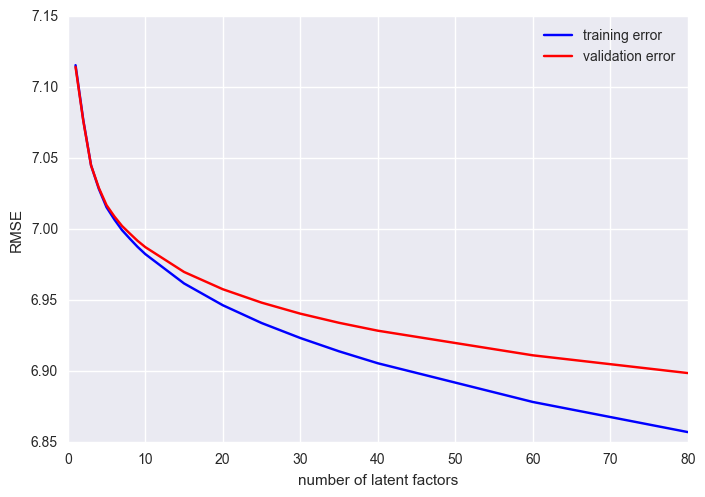

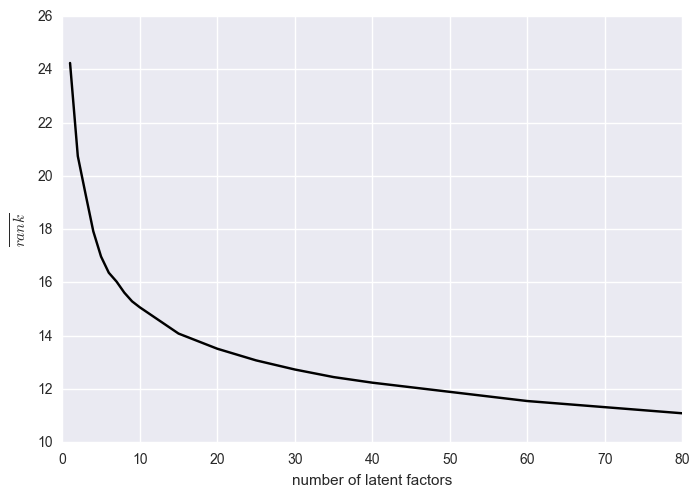

In [6]:
plt.plot(ranks,np.array(train_error),c='b')
plt.plot(ranks,np.array(val_error),c='r')
plt.xlabel('number of latent factors')
plt.ylabel('RMSE')
plt.legend(('training error','validation error'))
plt.show()
plt.plot(ranks,rbar,c='k')
plt.xlabel('number of latent factors')
plt.ylabel(r'$\overline{rank}$')
plt.show()

In [7]:
print('minimum validation error occurs at',ranks[val_error.index(min(val_error))],'latent factors')

minimum validation error occurs at 80 latent factors


We see that for the training and validation error behave roughly as expected. The validation error has not yet begun to increase indicating that we are not overfitting the dataset. The $\overline{rank}$ statistic also appears to be decreasing as expected with increased number of latent factors.

# Optimizing hyperparameters

I am going to assume that since I have over 1M ratings to validate on that my statistics on the validation error are reasonably good, so that I will only calculate the validation set error on a single validation set rather than doing cross validation as that would take too long on my local machine. Generally, a higher number of latent factors performs better, and I would like to set that to a reasonably high value, so I'll take 100 latent factors. I then check a couple different values of alpha and regularization. The final model is then chosen to be the one with the best $\overline{rank}$ metric.

In [13]:
hp_ranks=np.array([100])
hp_alpha=np.array([1,10])
hp_reg=np.array([0.01,0.1])
hp_val_error = []
hp_rbar=[]
hp_params = []
counter = 1
min_rbar = 100
for rank in hp_ranks:
    for a in hp_alpha:
        for r in hp_reg:
            als = ALS(rank=rank, maxIter=25,alpha=a,regParam=r, seed=0,coldStartStrategy='drop',implicitPrefs=True)
            model = als.fit(train_df)
            val_predictions = model.transform(validation_df)
            evaluator = RegressionEvaluator(metricName="rmse",
                                            labelCol="rating",
                                            predictionCol="prediction")
            val_rmse = evaluator.evaluate(val_predictions)
            hp_val_error.append(val_rmse)
            hp_params.append([rank,a,r])
            
            user_recs = model.recommendForAllUsers(1000)

            cond = [col('exp.user') == col('val.user'), col('exp.item') == col('val.item')]
            next_df = user_recs.select("user","recommendations.item",
                                                 "recommendations.rating")

            exploded=(next_df
                .withColumn("tmp", zip_("item"))
                # UDF output cannot be directly passed to explode
                .withColumn("tmp", explode("tmp"))
                .select("user", col("tmp.first").alias("item"), col("tmp.second").alias("percentile")))
            
            curr_rbar=(exploded.alias('exp').join(validation_df.alias('val'),
                            cond,'inner').rdd.map(lambda x: (1,[x[5],x[2]*x[5]])
                                                 ).reduceByKey(lambda x,y: [x[0]+y[0],x[1]+y[1]]
                                                              ).map(lambda x: x[1][1]/x[1][0]).collect())[0]
            hp_rbar.append(curr_rbar)
            
            if curr_rbar < min_rbar:
                
                best_params = [rank,a,r]
                
                best_model = model
                
                min_rbar=curr_rbar
                
            print('Iteration: '+str(counter)+' of 4. Score: '+str(val_rmse)+'. Rank: '+str(rank)+
                 '. Alpha: '+str(a)+'. Regularization: '+str(r)+'. RBar: '+str(curr_rbar))
            time.sleep(10)
            counter+=1

Iteration: 1 of 4. Score: 6.877701840138694. Rank: 100. Alpha: 1. Regularization: 0.01. RBar: 11.433941386534086
Iteration: 2 of 4. Score: 6.889209993466212. Rank: 100. Alpha: 1. Regularization: 0.1. RBar: 10.758359653282298
Iteration: 3 of 4. Score: 6.703375736557534. Rank: 100. Alpha: 10. Regularization: 0.01. RBar: 11.997721947278981
Iteration: 4 of 4. Score: 6.705042185490149. Rank: 100. Alpha: 10. Regularization: 0.1. RBar: 11.586942120788802


We see above that the best model has the default alpha and regularization parameters. Let's save our best model now.

In [4]:
als = ALS(rank=100, maxIter=25,alpha=1,regParam=0.1, seed=0,coldStartStrategy='drop',implicitPrefs=True)
best_model = als.fit(train_df)

In [5]:
best_model.save(local_path('als_matrix_factorization_model_rank_100_alpha_1_reg_0p1'))

# Trying out the recommender

Below I have a small widget which allows the user to select games that they wish to provide ratings for on a scale of 1 to 10. Once games have been selected, the user is asked to supply ratings. Finally, we will find the recommendations by assuming that the new user doesn't significantly alter the item factor matrix, finding the confidence vector $c_{u,i}$, the implicit preference vector $p(u)$, and computing $s^u_{i,j}$ which allows us to compute $\hat{p}_{u,i}$ put them in ranked order, and then for the top couple of items state the reason why an item was recommended.

In [6]:
index_to_game = load_obj('../DataAnalysis/index_to_name')

In [8]:
#convert games to corresponding index
game_to_index = {}
games = []
for k,v in index_to_game.items():
    
    game_to_index[v] = k
    games.append(v)

In [12]:
#create a widget for the user to select games
button = widgets.SelectMultiple(
    options=sorted(games),
    value=[('Gloomhaven')],
    rows=25,
    description='Games:',
    disabled=False
)

In [77]:
#command click to select multiple games
#I recommend using between 2 and 5 games for easily interpretable results
button

SelectMultiple(description='Games:', index=(148, 600, 680), options=('13 Days: The Cuban Missile Crisis', '1775: Rebellion', '1812: The Invasion of Canada', '1830: Railways & Robber Barons', '1846: The Race for the Midwest', '1856: Railroading in Upper Canada from 1856', '1960: The Making of the President', '1989: Dawn of Freedom', '5-Minute Dungeon', '51st State: Master Set', '6 nimmt!', '7 Wonders', '7 Wonders Duel', '878: Vikings – Invasions of England', 'A Distant Plain', 'A Fake Artist Goes to New York', 'A Feast for Odin', 'A Few Acres of Snow', 'A Game of Thrones (First Edition)', 'A Game of Thrones: The Board Game (Second Edition)', 'A Game of Thrones: The Card Game', 'A Game of Thrones: The Card Game (Second Edition)', 'A Study in Emerald', 'A Touch of Evil: The Supernatural Game', 'Above and Below', 'Abyss', 'Acquire', 'Ad Astra', 'Adrenaline', 'Advanced Squad Leader', 'Advanced Squad Leader: Starter Kit #1', 'Advanced Squad Leader: Starter Kit #2', 'Advanced Squad Leader: Starter Kit #3', "Aeon's End", "Aeon's End: War Eternal", 'Age of Empires III: The Age of Discovery', 'Age of Industry', 'Age of Renaissance', 'Age of Steam', 'Agra', 'Agricola', 'Agricola (Revised Edition)', 'Agricola: All Creatures Big and Small', 'Airlines Europe', 'Akrotiri', "Aladdin's Dragons", 'Alchemists', 'Alhambra', 'Alien Frontiers', 'Altiplano', 'Ambush!', 'Amerigo', 'Among the Stars', 'Amun-Re', 'Amyitis', 'Anachrony', 'Andean Abyss', 'Android: Netrunner', 'Animal Upon Animal', 'Antike', 'Antiquity', 'AquaSphere', 'Aquaretto', 'Arboretum', 'Arcadia Quest', 'Arcadia Quest: Inferno', 'Archaeology: The New Expedition', 'Archipelago', 'Architects of the West Kingdom', 'Argent: The Consortium', 'Arkadia', 'Arkham Horror', 'Arkham Horror (Third Edition)', 'Arkham Horror: The Card Game', 'Arkwright', 'Asara', 'Ascending Empires', 'Ascension: Deckbuilding Game', 'Ascension: Immortal Heroes', 'Ascension: Return of the Fallen', 'Ascension: Storm of Souls', 'Ashes: Rise of the Phoenixborn', 'At the Gates of Loyang', 'Aton', 'Attika', 'AuZtralia', 'Automania', 'Automobile', 'Automobiles', 'Axis & Allies Anniversary Edition', 'Axis & Allies Europe 1940', 'Azul', 'Azul: Stained Glass of Sintra', 'BANG! The Dice Game', 'Balloon Cup', 'Baseball Highlights: 2045', 'Battle Cry', 'Battle Line', 'BattleCON: Devastation of Indines', 'BattleCON: War of Indines', 'BattleLore', 'BattleLore (Second Edition)', 'BattleTech', 'Battles of Westeros', 'Battlestar Galactica: The Board Game', 'Bausack', 'Belfort', 'Betrayal Legacy', 'Betrayal at House on the Hill', 'Between Two Castles of Mad King Ludwig', 'Between Two Cities', 'Biblios', 'Black Fleet', 'Black Orchestra', 'Blokus', 'Blokus 3D', 'Blokus Duo', 'Blokus Trigon', 'Blood Bowl (2016 edition)', 'Blood Bowl (Third Edition)', 'Blood Bowl: Living Rulebook', 'Blood Bowl: Team Manager – The Card Game', 'Blood Rage', 'Blue Moon', 'Blue Moon City', 'Blueprints', 'Bohnanza', 'Bora Bora', 'Brass: Birmingham', 'Brass: Lancashire', 'Brew Crafters', 'Bridge', 'Britannia', 'Broom Service', 'Bruges', 'Bruxelles 1893', 'Bunny Kingdom', 'Burgle Bros.', 'Bärenpark', 'CO₂', 'CV', "Ca$h 'n Gun$", "Ca$h 'n Guns (Second Edition)", 'Cacao', 'Call of Cthulhu: The Card Game', 'Camel Up', "Can't Stop", 'Captain Sonar', 'Carcassonne', 'Carcassonne: Hunters and Gatherers', 'Carcassonne: South Seas', 'Carcassonne: The Castle', 'Carcassonne: The City', 'Carcassonne: Winter Edition', 'Carolus Magnus', 'Carpe Diem', 'Carson City', 'Cartagena', 'Castle Panic', 'Castles of Mad King Ludwig', 'Catacombs', 'Catacombs (third edition)', 'Catan', 'Catan Card Game', 'Caverna: Cave vs Cave', 'Caverna: The Cave Farmers', 'Caylus', 'Caylus Magna Carta', 'Celestia', 'Century: Eastern Wonders', 'Century: Golem Edition', 'Century: Spice Road', 'Champions of Midgard', 'Chaos in the Old World', 'Charterstone', 'Chess', 'Chicago Express', 'Chimera Station', 'China', 'Chinatown', 'Chronicles of Crime', 'Churchill', 'Citadels', 'Citadels', 'City of Iron', 'Ci

In [78]:
#Collect ratings
ratings = []
indicies = []
for x in button.value:
    
    rating = input('please provide a rating between 1 and 10 for game '+x+' : ')
    
    ratings.append(rating)
    
    indicies.append(game_to_index[x])

please provide a rating between 1 and 10 for game Catan : 5.0
please provide a rating between 1 and 10 for game Root : 9.8
please provide a rating between 1 and 10 for game The Captain Is Dead : 8.5


In [79]:
# Get recommendations based on previously trained model
Y = item_array
Y_T = np.transpose(item_array)
rank = 100
alpha=1
lambda_=0.1
c_u = np.ones(1000)
for i in range(len(ratings)):
    c_u[indicies[i]] = 1+alpha*round(float(ratings[i]),3)
C = np.diag(c_u)
Lambda = np.diag([lambda_ for x in range(rank)])
W_u = np.linalg.inv(np.matmul(np.matmul(Y_T,C),Y)+Lambda)
s = np.matmul(np.matmul(Y,W_u),Y_T)
c_restricted = (c_u>1)*c_u
recommendations = np.matmul(s,c_restricted)

In [81]:
#Let's look at the top 100 items recommended to me based on the input ratings
unsorted_recs = zip(list(recommendations),range(len(recommendations)))
recs = sorted(unsorted_recs,reverse=True)
position = 0
rated=len(indicies)
print('You provided ratings for '+str(rated)+' games. The remaining '+str(1000-rated)+
      ' games are recommended in the order below:\n')
for r in recs:
    
    if position <100:
    
        if r[1] not in indicies:
            important_items = s[r[1],c_restricted!=0]*c_restricted[c_restricted!=0]
            items = sorted(zip(list(important_items),indicies))
            games = [index_to_game[item[1]] for item in items]
            print(index_to_game[r[1]]+' score: ',str(r[0]))
            print('Order of importance for your historic items:\n',str(games)+'\n')
    position+=1

You provided ratings for 3 games. The remaining 997 games are recommended in the order below:

Vast: The Crystal Caverns score:  0.36021208204076915
Order of importance for your historic items:
 ['Root', 'The Captain Is Dead', 'Catan']

Spirit Island score:  0.3562455041517399
Order of importance for your historic items:
 ['Root', 'The Captain Is Dead', 'Catan']

Burgle Bros. score:  0.2569238719682103
Order of importance for your historic items:
 ['Root', 'Catan', 'The Captain Is Dead']

Everdell score:  0.25223229771542705
Order of importance for your historic items:
 ['Root', 'The Captain Is Dead', 'Catan']

Kingdom Death: Monster score:  0.24268730153186036
Order of importance for your historic items:
 ['The Captain Is Dead', 'Catan', 'Root']

Secret Hitler score:  0.23956694550985458
Order of importance for your historic items:
 ['Root', 'The Captain Is Dead', 'Catan']

Wingspan score:  0.2298386574585537
Order of importance for your historic items:
 ['Root', 'The Captain Is Dead'

# Final thoughts:

Having played around with the recommender a bit, I can say that when I put 2-5 of the games in my collection in with my rating on a 1 to 10 scale, the system recommends several games in the top 20 that are also in my collection, and that I would rate highly. It also recommends some games which I don't have, but upon research feel I would like. While the previous statement is qualitative and should be taken with a grain of salt, the combination of this anecdote with the observed value of $\overline{rank} << 50\%$ indicate that this is a recommender system that does do significantly better than a random recommendation. When putting in too many games, the recommendation quality seems to reduce, however, I think this is likely just because it increases the coverage of games recommended in the top 100. I will leave investigating this problem to future work after I try several other recommendation algorithms and choose the best one according to the $\overline{rank}$ metric.